In [1]:
# accessing APIs and URLs
import requests

# handling of JSON responses
import json
from pprint import pprint
from pandas import json_normalize

# general data handling
# note: you need to additionally install geopy
import geopandas as gpd
import pandas as pd

# static web scraping
from urllib.request import urlopen
from lxml.html import parse, fromstring

# selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

import time
import seaborn as sns
import matplotlib.pyplot as plt

Scraping the Data from the Web

In [2]:
df = pd.read_csv("mdb_socialmedia_20240306.csv")
df[['Name', 'Party']] = df['Name and Party'].str.split(', ', expand=True)
df = df.drop(columns=['Name and Party'])
df["Social Media"] = df["Social Media"].str.strip('[').str.strip(']').str.split(', ')
df["Links"] = df["Links"].str.strip('[').str.strip(']').str.split(', ')
df = df[['Name','Party', 'Social Media', 'Links']]
df_long = df.explode(['Social Media', 'Links'])
df_long["Social Media"] = df_long["Social Media"].str.strip("'").str.strip().astype(str)
df_long["Links"] = df_long['Links'].str.strip("'").astype(str).str.strip().astype(str)
df_long["Party"] = df_long["Party"].str.replace('\n', '').str.strip('*').str.strip()
df_long

,Name,Party,Social Media,Links
0,Markus Frohnmaier,AfD,,
1,Judith Skudelny,FDP,Homepage,https://www.judith-skudelny.de/
1,Judith Skudelny,FDP,Facebook,https://www.facebook.com/judith.skudelny
2,Michael Grosse-Brömer,CDU/CSU,Homepage,http://www.m-grosse-broemer.de
2,Michael Grosse-Brömer,CDU/CSU,Facebook,https://www.facebook.com/MGrosseBroemer/
...,...,...,...,...
733,Stefan Schmidt,Bündnis 90/Die Grünen,Instagram,https://www.instagram.com/stefan_schmidt_mdb/
734,Brian Nickholz,SPD,Homepage,https://www.brian-nickholz.de
734,Brian Nickholz,SPD,X,https://twitter.com/BrianNickholz
734,Brian Nickholz,SPD,Instagram,https://www.instagram.com/briannickholz/


In [3]:
df_long['Social Media'] = df_long['Social Media'].replace(['Tik Tok', 'Tiktok'], 'TikTok')
df_long['Social Media'] = df_long['Social Media'].replace(['Linkedin'], 'LinkedIn')
df_long['Social Media'] = df_long['Social Media'].replace(['Insatgram', 'Instgram'], 'Instagram')
df_long['Social Media'] = df_long['Social Media'].replace('X', 'Twitter')
df_long['Social Media'] = df_long['Social Media'].replace(['Youtube', 'youtube'], 'YouTube')
df_long['Social Media'] = df_long['Social Media'].replace(['felixbanaszak.de','karlheinz-busen.de', 'katharina-willkomm.de', 'homepage'], 'Homepage')
df_long['Social Media'] = df_long['Social Media'].replace('sonstige Website', 'Mastodon')
df_long['Social Media'] = df_long['Social Media'].replace('homepage', 'Homepage')
df_long.loc[(df_long['Name'] == 'Valentin Abel') & (df_long['Social Media'] == 'Sonstige Website'),'Social Media'] = 'LinkedIn'
df_long = df_long[df_long['Social Media'] != 'http://']
df_long[df_long == ''] = None
df_long = df_long.loc[df_long['Social Media'] != "E-Mail",:]

/var/folders/tn/90jm_wh175q5jckf2wwg3z0r0000gn/T/ipykernel_4318/2648999776.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long[df_long == ''] = None
/var/folders/tn/90jm_wh175q5jckf2wwg3z0r0000gn/T/ipykernel_4318/2648999776.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long[df_long == ''] = None


In [4]:
df_long.groupby(['Social Media'])['Name'].count()

Social Media
Bluesky               1
Facebook            677
Flickr                1
Gettr                 5
Homepage            703
Instagram           594
LinkedIn            127
Mastodon              1
Newsletter            1
Sonstige Website      2
Telegram             11
TikTok               12
Twitch                1
Twitter             513
Xing                  8
YouTube              68
Name: Name, dtype: int64

In [5]:
df_long[df_long['Social Media'] == 'Bluesky']

,Name,Party,Social Media,Links
446,Leon Eckert,Bündnis 90/Die Grünen,Bluesky,https://www.bsky.app/profile/leon-eckert.de


In [6]:
df_long[df_long['Social Media'] == 'Flickr']

,Name,Party,Social Media,Links
597,Heike Brehmer,CDU/CSU,Flickr,https://www.flickr.com/photos/heikebrehmer


In [7]:
df_long[df_long['Social Media'] == 'Mastodon']

,Name,Party,Social Media,Links
408,Maik Außendorf,Bündnis 90/Die Grünen,Mastodon,https://gruene.social/web/accounts/56127


In [8]:
df_long[df_long['Social Media'] == 'Newsletter']

,Name,Party,Social Media,Links
244,Marja-Liisa Völlers,SPD,Newsletter,https://www.marjavoellers.de/newsletter-abonni...


In [9]:
df_long[df_long['Social Media'] == 'Twitch']

,Name,Party,Social Media,Links
485,Mario Brandenburg (Südpfalz),FDP,Twitch,https://www.twitch.tv/mariobrandenburg


In [10]:
df_long[df_long['Social Media'] == 'Gettr']

,Name,Party,Social Media,Links
55,Gerrit Huy,AfD,Gettr,https://www.gettr.com/user/gerrithuy
90,Norbert Kleinwächter,AfD,Gettr,https://https://gettr.com/user/kleinwaechter
160,Eugen Schmidt,AfD,Gettr,https://gettr.com/user/eugenschmidtmdb
175,Martin Sichert,AfD,Gettr,https://gettr.com/user/martinsichert
635,Roger Beckamp,AfD,Gettr,https://gettr.com/user/rogerbeckampmdb


In [11]:
df_long.loc[:,'Social Media'] = df_long['Social Media'].replace(['Bluesky', 'Flickr', 'Mastodon', 'Newsletter', 'Twitch', 'Gettr', 'Sonstige Website'], 'Sonstige')
df_long = df_long.loc[df_long['Social Media']!='Sonstige',:]

In [12]:
SM_counts = df_long.groupby(['Social Media'])['Name'].count().sort_values(ascending = False)
SM_order = SM_counts.index.tolist()
SM_counts

Social Media
Homepage     703
Facebook     677
Instagram    594
Twitter      513
LinkedIn     127
YouTube       68
TikTok        12
Telegram      11
Xing           8
Name: Name, dtype: int64

<Axes: xlabel='Social Media'>

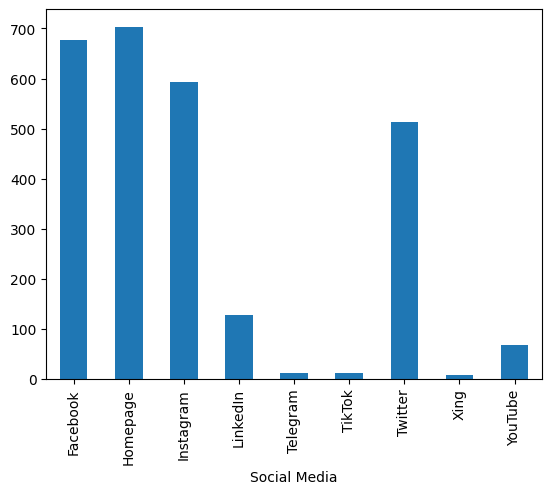

In [13]:
df_long.groupby(['Social Media'])['Name'].count().plot.bar()

In [14]:
df_long = df_long.groupby(['Social Media', 'Party'], as_index = False)['Name'].count()
df_long = df_long.rename(columns={"Social Media": "Kommunikationskanal", "Name": "Anzahl", "Party" : "Partei"})
df_long.head()

,Kommunikationskanal,Partei,Anzahl
0,Facebook,AfD,75
1,Facebook,Bündnis 90/Die Grünen,102
2,Facebook,CDU/CSU,176
3,Facebook,FDP,87
4,Facebook,Gruppe BSW,10


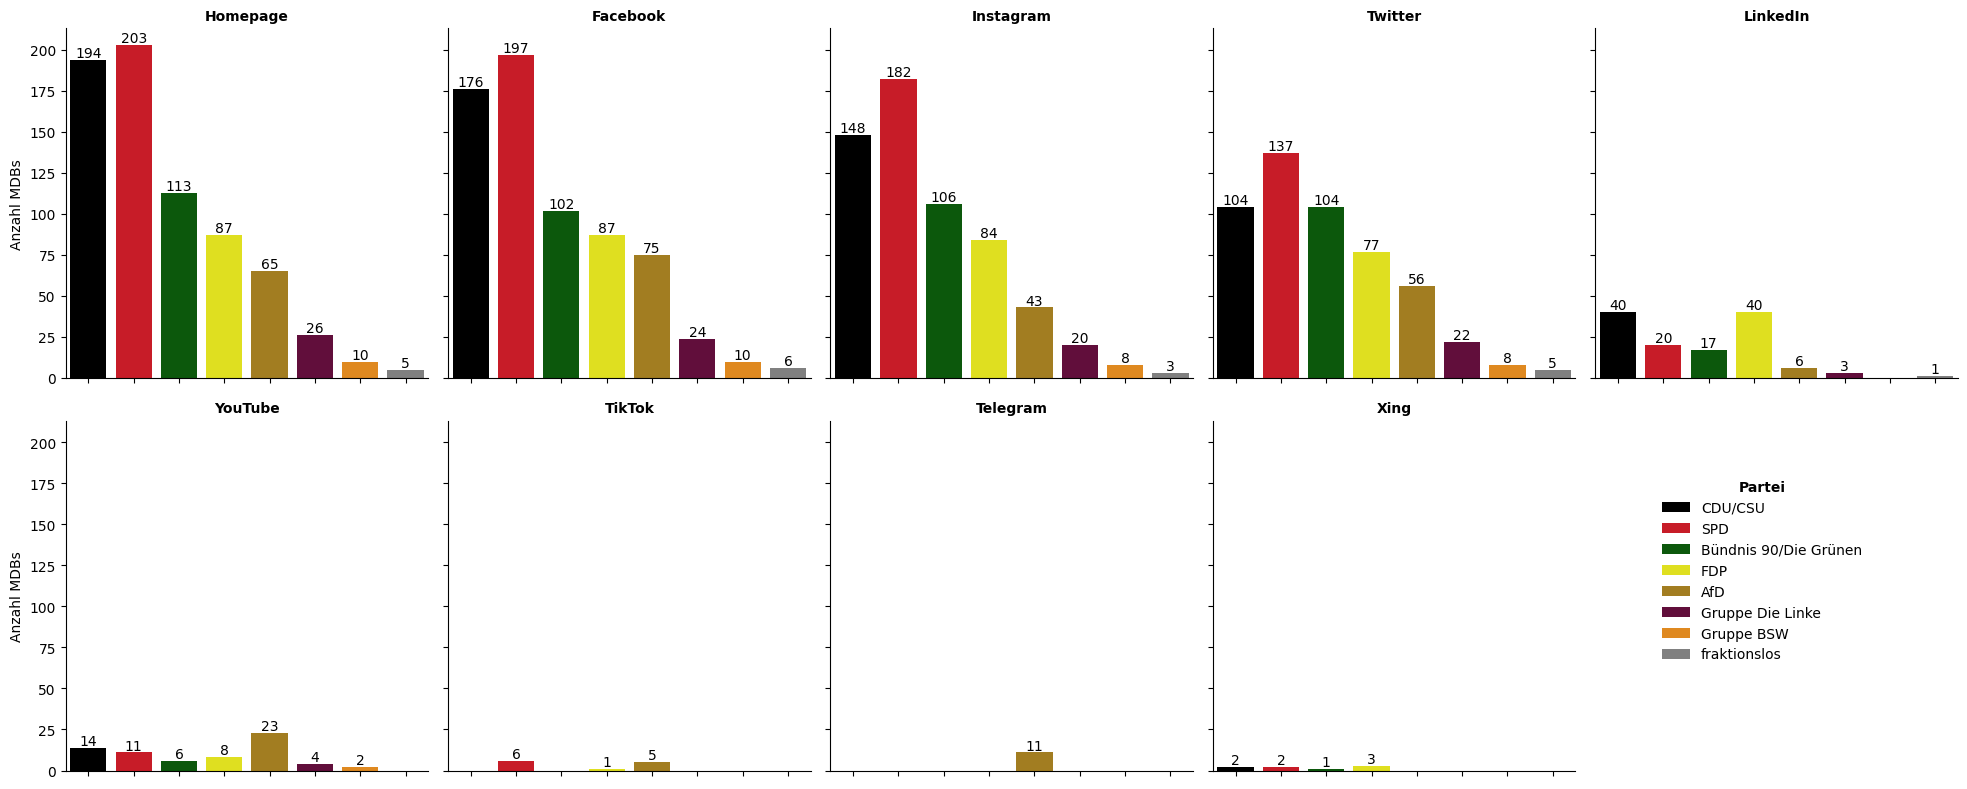

In [15]:
partei_farben ={
    'CDU/CSU': 'black' ,
    'SPD': '#E3000F', 
    'Bündnis 90/Die Grünen': 'darkgreen', 
    'FDP': 'yellow', 
    'AfD': 'darkgoldenrod',  
    'Gruppe Die Linke': '#6F003C',
    'Gruppe BSW': 'darkorange',
    'fraktionslos':   'grey'
}

g = sns.FacetGrid(df_long, col="Kommunikationskanal", 
                  col_wrap = 5, 
                  height=4, 
                  aspect=1, 
                  hue = "Partei", 
                  col_order = SM_order, 
                  palette = partei_farben)
g.map(sns.barplot, "Partei", "Anzahl", order = partei_farben.keys())
g.set_titles(col_template = '{col_name}', weight='bold')
g.set(xticklabels=[], xlabel=None, ylabel = "Anzahl MDBs")
g.add_legend(label_order = partei_farben.keys(), loc='lower right',bbox_to_anchor=(.85, 0.15))
plt.setp(g._legend.get_title(), weight = "bold")
g.tight_layout()
for ax in g.axes: #https://stackoverflow.com/a/57256238
    for p in ax.patches:
             ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', color='black', xytext=(0, 5),
                 textcoords='offset points')
sns.set_context("notebook", font_scale=1)
g.savefig("MdB_kommunkation.png")